# Supernovae population for the Roman survey
In this notebook, we simulate population of lensed supernovae for the Roman survey. It follows following steps:

1. Simulate lensed supernovae population
2. Choose 10 lenses at random
3. Display their lightcurves

Before running this notebook, please download the download psfs from cached_webb_psf
(https://github.com/LSST-strong-lensing/data_public/webbpsf), where the
psfs have been generated ahead of time so that they can be loaded from a file.

In [2]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import slsim
from slsim.Lenses.lens_pop import LensPop
from slsim.Pipelines.roman_speclite import configure_roman_filters
from slsim.Pipelines.roman_speclite import filter_names
import speclite
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
import slsim.Sources as sources
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines


In [3]:
slsim.__version__

'0.1.1'

## Set Roman configurations

In [2]:
# Import default Roman Space Telescope configuration
path = os.path.dirname(slsim.__file__)
module_path, _ = os.path.split(path)
skypy_config = os.path.join(module_path, "data/SkyPy/euclid-roman-lsst-like.yml")

# generate Roman filters
configure_roman_filters()

# import filter bands and make them recogniable in speclite
roman_filters = filter_names()
# filters are ['Roman-F062', 'Roman-F087', 'Roman-F106', 'Roman-F129', 'Roman-F158', 'Roman-F184', 'Roman-F146', 'Roman-F213']

speclite.filters.load_filters(
    roman_filters[0],
    roman_filters[1],
    roman_filters[2],
    roman_filters[3],
    roman_filters[4],
    roman_filters[5],
    roman_filters[6],
    roman_filters[7],
)

## Simulate lensed supernovae population

In [3]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
deflector_sky_area = Quantity(value=.05, unit="deg2")
source_sky_area = Quantity(value=.10, unit="deg2")
host_sky_area = Quantity(value=.02, unit="deg2")
sky_area = Quantity(value=100, unit="deg2")

# define limits in the intrinsic deflector and source population (in addition to the skypy config file)
kwargs_deflector_cut = {"band": "F184", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"z_min": 0.01, "z_max": 5}

time_range = np.linspace(-50, 500, 550)
modeldir = "/pscratch/sd/e/emlin/lensedsupernovae/data_public/sncosmo_sn_models/SALT3.NIR_WAVEEXT"

In [4]:
# generate galaxy population.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=skypy_config, sky_area=deflector_sky_area, filters=None, cosmo=cosmo
)

# generate galaxy population for host galaxy candidates.
galaxy_simulation_pipeline_host = pipelines.SkyPyPipeline(
    skypy_config=skypy_config, sky_area=host_sky_area, filters=None, cosmo=cosmo
)

# Initiate deflector population class
lens_galaxies = deflectors.EllipticalLensGalaxies(
    galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=deflector_sky_area,
)

# generate supernovae population
supernovae_catalog = sources.SupernovaeCatalog.SupernovaeCatalog(
    sn_type="Ia",
    band_list=["F184", "F129", "F062"],
    lightcurve_time=time_range,
    absolute_mag_band="bessellb",
    absolute_mag=None,
    mag_zpsys="ab",
    cosmo=cosmo,
    skypy_config=skypy_config,
    sky_area=source_sky_area,
    host_galaxy_candidate=galaxy_simulation_pipeline_host.blue_galaxies,
)
supernovae_data = supernovae_catalog.supernovae_catalog(
    host_galaxy=True, lightcurve=False
)

/pscratch/sd/e/emlin/lensedsupernovae/slsim/slsim/Deflectors/DeflectorPopulation/elliptical_lens_galaxies.py:48: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  galaxy_list = param_util.catalog_with_angular_size_in_arcsec(
/pscratch/sd/e/emlin/lensedsupernovae/slsim/slsim/Sources/Supernovae/supernovae_pop.py:95: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  numerator = integrate.quad(
/pscratch/sd/e/emlin/lensedsupernovae/slsim/slsim/Sources/Superno

In [5]:
kwargs_sn = {
    "variability_model": "light_curve",
    "kwargs_variability": {"supernovae_lightcurve", "F184", "F129", "F062"},
    "sn_type": "Ia",
    "sn_absolute_mag_band": "bessellb",
    "sn_absolute_zpsys": "ab",
    "lightcurve_time": np.linspace(-50, 100, 150),
    "sn_modeldir": modeldir,
}

source_SNIa = sources.PointPlusExtendedSources(
    point_plus_extended_sources_list=supernovae_data,
    cosmo=cosmo,
    sky_area=source_sky_area,
    kwargs_cut=kwargs_source_cut,
    catalog_type="skypy",
    source_size=None,
    point_source_type='supernova',
    point_source_kwargs=kwargs_sn,
    extended_source_type='single_sersic'
)

# Initiate LensPop class
lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_SNIa,
    cosmo=cosmo,
    sky_area=sky_area,
)

# Draw lens population
kwargs_lens_cut = {"min_image_separation": 0.1, "max_image_separation": 10}
lens_population = lens_pop.draw_population(
    kwargs_lens_cuts=kwargs_lens_cut, speed_factor=10
)

## Plot lightcurves

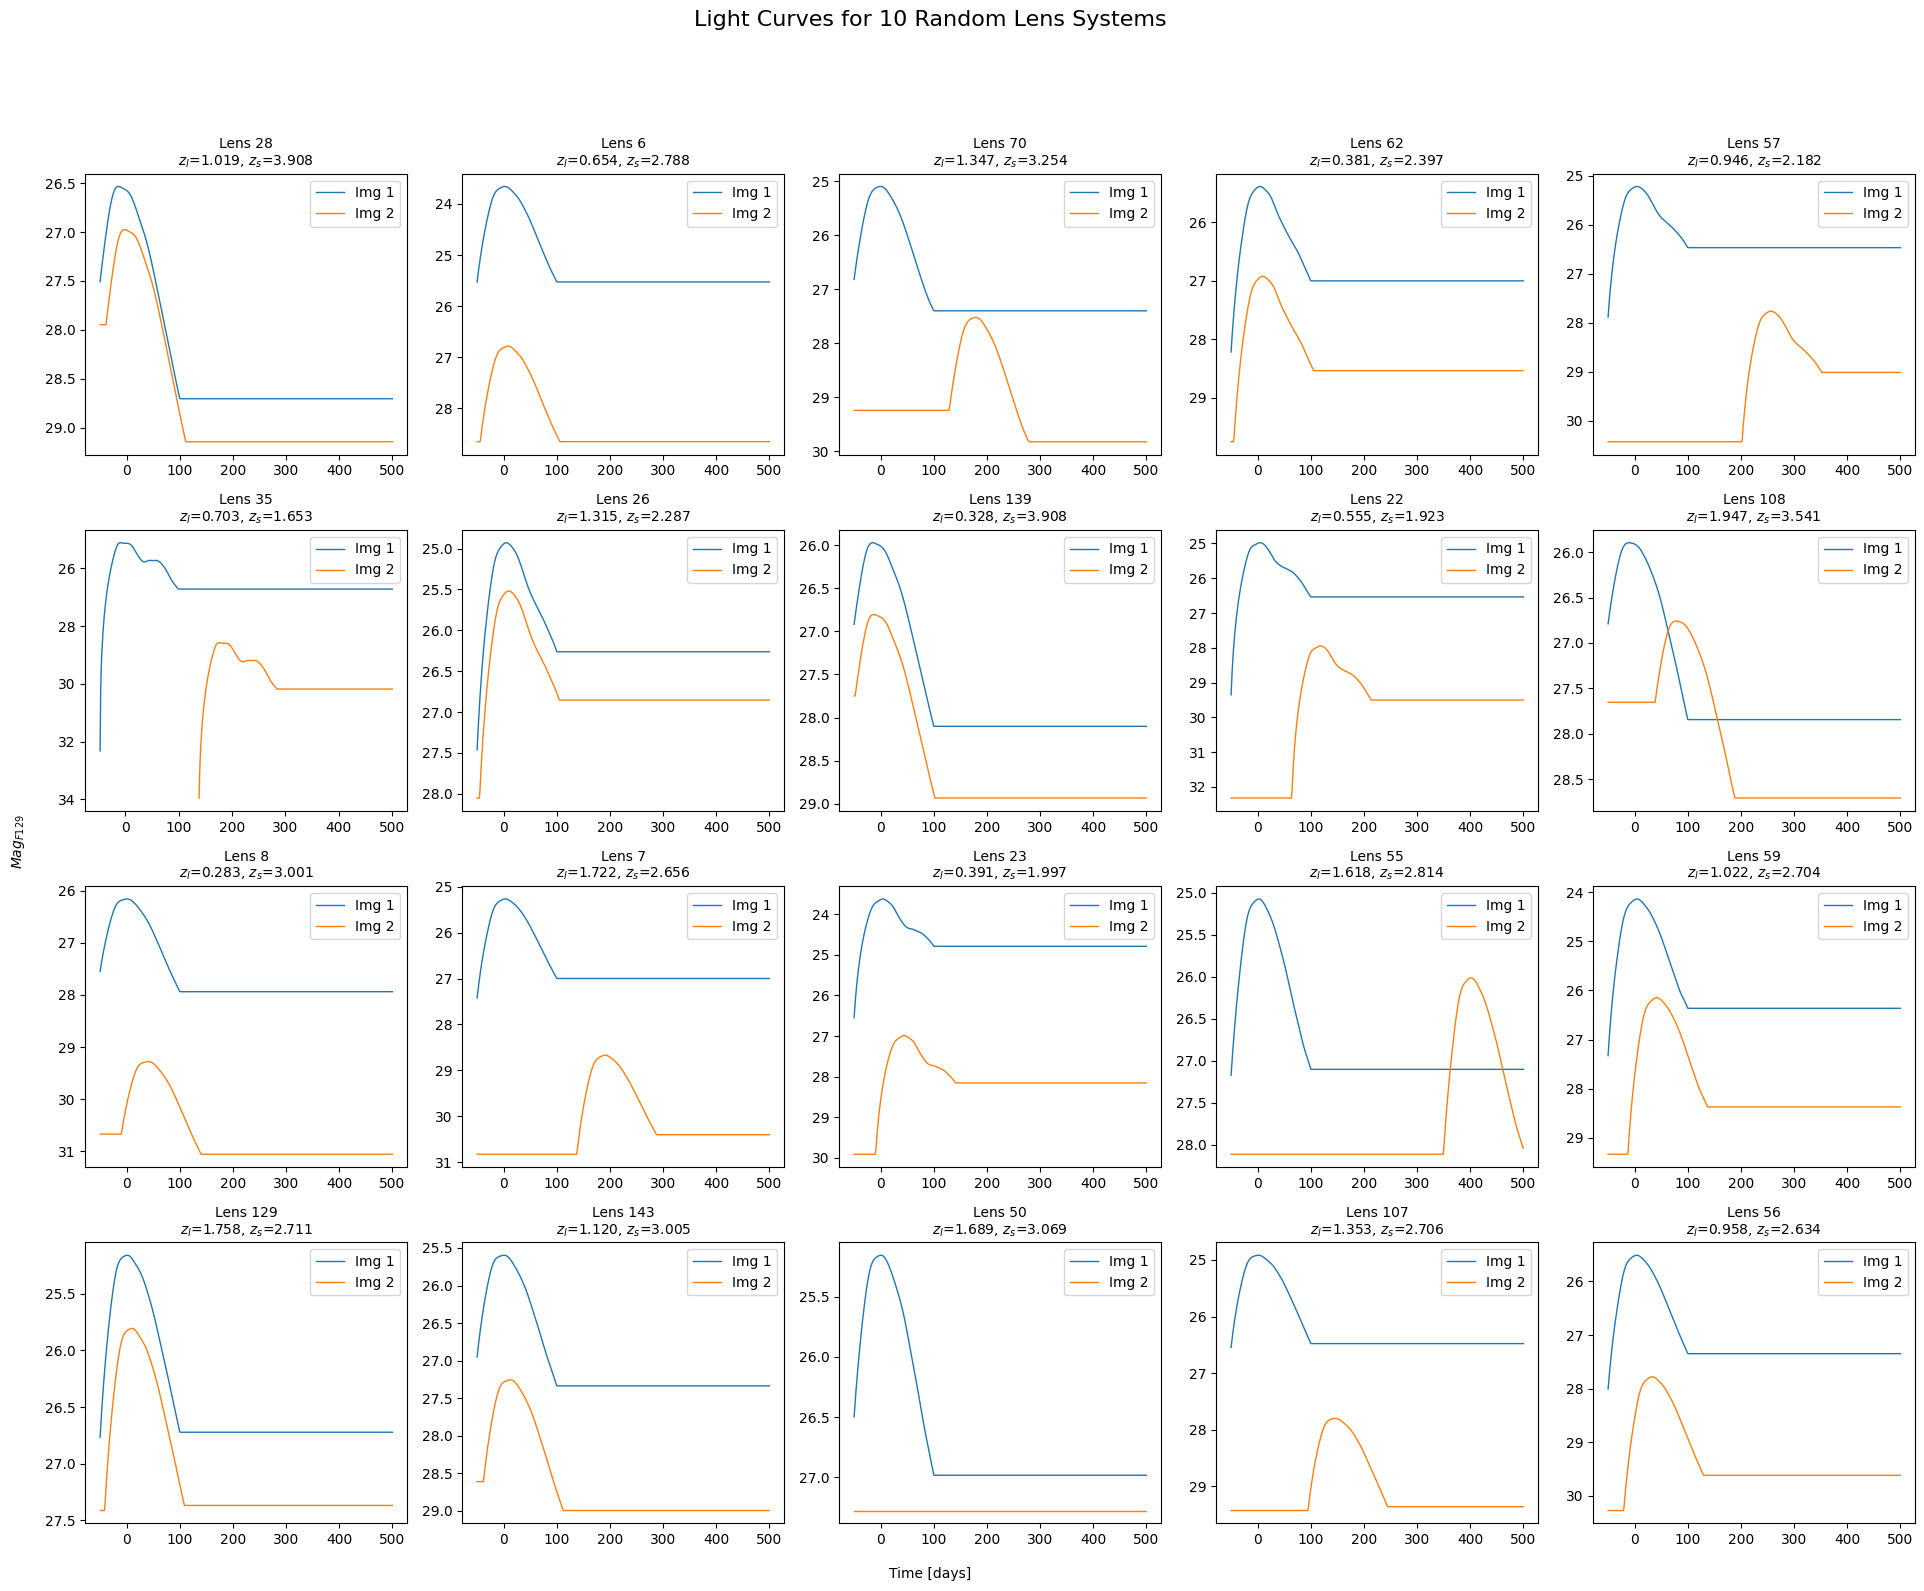

In [10]:
random.seed(42)

random_indices = random.sample(range(len(lens_population)), 20)

fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

times = np.linspace(-50, 500, 500)

for ax, idx in zip(axes, random_indices):
    lens_class = lens_population[idx]
    magnitude = lens_class.point_source_magnitude(
        band="F184", lensed=True, time=times
    )
    
    zl = lens_class.deflector_redshift
    zs = lens_class.source_redshift_list[0]

    for i in range(len(magnitude[0])): 
        ax.plot(times, magnitude[0][i], label=f"Img {i+1}", lw=1)

    ax.invert_yaxis()
    ax.set_title(f"Lens {idx}\n$z_l$={zl:.3f}, $z_s$={zs:.3f}", fontsize=10)
    ax.legend()

fig.text(0.5, 0.04, "Time [days]", ha="center")
fig.text(0.04, 0.5, r"$Mag_{F129}$", va="center", rotation="vertical")

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.suptitle("Light Curves for 10 Random Lens Systems", fontsize=16, y=1.02)
plt.show()

Notes:
- strange that light doesn't go down and just plateaus on most of these
    - ex. Lens 42, 21, 115, etc.
- even when there is a defined peak, the light still just plateaus
    - ex. Lens 48, 93, 84, etc.
- These should all be Type 1a supernovae and none of these look like Type 1a supernovae light curves
- sometimes they peak, go down, and then peak again -> ???
    - ex. Lens 29, 115, 70
- some very long time delays
    - Lens 36, 49, 99
    - especially for 49 and 99, presumably the light peaks after 500 days-- the range in time is just too small to see
- Lens 109: most plausible Type 1a supernova light curve, the light peaks and then decreases in ~60 days
    - however, it still doesn't go down all the way.
  